In [1]:
import csv
import cv2
import numpy as np
import matplotlib.pyplot as plt
from random import random
%matplotlib inline

images = []
measurements = []

# Select which datasets to use for training
# Thought about making this automatic, but wanted ability to select individual datasets
#datasets = ['Train1', 'Train4', 'Train6', 'Train7']
datasets = ['Train1', 'Train4', 'Train6', 'Train7', 'Train8', 'Train9', 'Train11', 'Train12']


samples = []
steer_correct = [0, 0.20, -0.20]

steer_angle_thresh = 0.04
steer_keep_pct = .33 # percentage of steering angles withn +/- steering threshold to keep

# Loop thorugh selected datasets

# Note: makes sense to do preprocessing here so batch size is properly attributed in the generator below

for dataset in datasets:
    tot_counter = 0;
    dataset_counter = 0;
    with open('data/' + dataset + '_log.csv') as csvfile:
        reader = csv.reader(csvfile)
        
        for line in reader:
            tot_counter = tot_counter + 1
            # Filter out steering angles
            this_steer = float(line[3])
            
            if (((this_steer <= -steer_angle_thresh) | (this_steer >= steer_angle_thresh))  | 
                ((this_steer >= -steer_angle_thresh) & (this_steer <= steer_angle_thresh) & (random() < steer_keep_pct))):
                
                # create a new line for center, left, right
                for i in range(3): # center, left, right
                    
                    sourcepath = line[i]
                    
                    if("/" in sourcepath):
                        filename = sourcepath.split('/')[-1]
                    else:
                        filename = sourcepath.split('\\')[-1]

                    newpath = 'data/' + dataset + '/' + filename

                    newline = [newpath, this_steer+steer_correct[i]]            
                    samples.append(newline)
                    dataset_counter = dataset_counter + 1 
            
    
    print("Total number of images in", dataset, ": " , tot_counter*3)
    print("Number of images in", dataset, "after fitering : ", dataset_counter)

print("Final number of images: ", len(samples))

print("NOTE: This does not include any image flipping, which may occur later!")


Total number of images in Train1 :  4515
Number of images in Train1 after fitering :  2598
Total number of images in Train4 :  3747
Number of images in Train4 after fitering :  3321
Total number of images in Train6 :  4218
Number of images in Train6 after fitering :  3537
Total number of images in Train7 :  4110
Number of images in Train7 after fitering :  3957
Total number of images in Train8 :  12300
Number of images in Train8 after fitering :  11181
Total number of images in Train9 :  14712
Number of images in Train9 after fitering :  13356
Total number of images in Train11 :  4869
Number of images in Train11 after fitering :  3765
Total number of images in Train12 :  3234
Number of images in Train12 after fitering :  2721
Final number of images:  44436
NOTE: This does not include any image flipping, which may occur later!


(array([  14.,   18.,   16.,  148.,  268.,  330.,  231.,  838.,  750.,
        1031., 1377., 1392., 1322., 1695., 2693., 1676., 2085., 1800.,
        2753., 1550., 1898., 1557., 2284., 1826., 1851., 1168., 1324.,
        1622.,  896., 1136., 1081., 1063.,  830.,  823.,  549.,  510.,
         392.,  359.,  228.,  207.,  281.]),
 array([-1.        , -0.95121951, -0.90243902, -0.85365854, -0.80487805,
        -0.75609756, -0.70731707, -0.65853659, -0.6097561 , -0.56097561,
        -0.51219512, -0.46341463, -0.41463415, -0.36585366, -0.31707317,
        -0.26829268, -0.2195122 , -0.17073171, -0.12195122, -0.07317073,
        -0.02439024,  0.02439024,  0.07317073,  0.12195122,  0.17073171,
         0.2195122 ,  0.26829268,  0.31707317,  0.36585366,  0.41463415,
         0.46341463,  0.51219512,  0.56097561,  0.6097561 ,  0.65853659,
         0.70731707,  0.75609756,  0.80487805,  0.85365854,  0.90243902,
         0.95121951,  1.        ]),
 <a list of 41 Patch objects>)

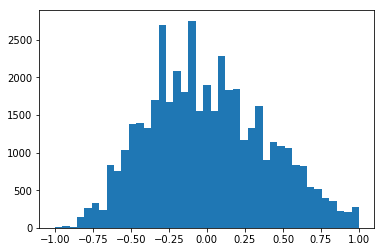

In [2]:
angles = []
for sample in samples:
    angles.append(sample[1])

plt.hist(angles, bins=41, range=(-1.0, 1.0))
    

In [6]:
from sklearn.model_selection import train_test_split
import sklearn

# Split training and validation sets
train_samples, validation_samples = train_test_split(samples, test_size=0.2)            


def generator(samples, batch_size = 64):
    # Center, Left, Right
    steer_correct = [0, 0.20, -0.20]
    num_samples = len(samples)
    
    while 1:
        for offset in range(0, num_samples, batch_size):
            
            batch_samples = samples[offset:offset+batch_size]

            images = []
            angles = []
            for batch_sample in batch_samples:
                    
                path = batch_sample[0]
                angle = batch_sample[1]

                image = cv2.imread(path)
                #plt.imshow(image)
                
                image = cv2.cvtColor(image, cv2.COLOR_BGR2YUV) # Suggested by nvidia
                images.append(image)
                images.append(cv2.flip(image,1)) #Flip image

                angles.append(float(angle))
                angles.append(float(-angle))

            
            X_train = np.array(images)
            y_train = np.array(angles)
            yield sklearn.utils.shuffle(X_train, y_train)
        
train_generator = generator(train_samples, batch_size=128)
validation_generator = generator(validation_samples, batch_size=128)


In [8]:
## Set Up NNs ##
from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda, Cropping2D, Convolution2D, MaxPooling2D, Dropout


dropout = [0.0, 0.3, 0.3, 0.5]


def LeNet1():
	model = Sequential()
	model.add(Cropping2D(cropping=((50,20), (0,0)), input_shape=(160, 320, 3)))
	model.add(Lambda(lambda x:(x/255.0)-0.5))
	model.add(Convolution2D(10, 5, 5, activation='relu'))
	model.add(MaxPooling2D())
	model.add(Convolution2D(20, 5, 5, activation='relu'))
	model.add(MaxPooling2D())
	model.add(Flatten())
	model.add(Dense(120))
	model.add(Dense(84))
	model.add(Dense(1))

	model.compile(loss = 'mse', optimizer = 'adam')
	model.fit(X_train, y_train, validation_split=0.2, shuffle=True, nb_epoch=7, batch_size=128)

	model.save('model.h5')

def nvidia():

	model = Sequential()
	model.add(Cropping2D(cropping=((50,20), (0,0)), input_shape=(160, 320, 3)))
	model.add(Lambda(lambda x:(x/255.0)-0.5))
	model.add(Convolution2D(24, 5, 5, subsample=(2,2), activation='relu'))#78x158
	model.add(Dropout(dropout[1]))
	model.add(Convolution2D(36, 5, 5, subsample=(2,2), activation='relu'))#37x77
	model.add(Dropout(dropout[1]))
	model.add(Convolution2D(48, 5, 5, subsample=(2,2), activation='relu'))#16x36
	model.add(Dropout(dropout[1]))
	model.add(Convolution2D(64, 5, 5, subsample=(2,2), activation='relu'))#2x17
	model.add(Dropout(dropout[1]))
	#model.add(Convolution2D(64, 5, 5, subsample=(2,1), activation='relu'))#1x12
	model.add(Flatten())
	model.add(Dense(1000))
	model.add(Dropout(dropout[3]))
	model.add(Dense(100))
	model.add(Dense(50))
	model.add(Dense(1))

	model.compile(loss = 'mse', optimizer = 'adam')
	model.fit(X_train, y_train, validation_split=0.2, shuffle=True, nb_epoch=3, batch_size=512)

	model.save('model.h5')

def nvidia1():

	model = Sequential()
	model.add(Cropping2D(cropping=((74,20), (30,30)), input_shape=(160, 320, 3))) # 66, 260
	model.add(Lambda(lambda x:(x/255.0)-0.5))
	model.add(Convolution2D(24, 5, 5, subsample=(2,2), activation='relu'))#31x98
	model.add(Dropout(dropout[1]))
	model.add(Convolution2D(36, 5, 5, subsample=(2,2), activation='relu'))#14X47
	model.add(Dropout(dropout[1]))
	model.add(Convolution2D(48, 5, 5, subsample=(2,2), activation='relu'))#5x22
	model.add(Dropout(dropout[1]))
	model.add(Convolution2D(64, 3, 3, subsample=(1,1), activation='relu'))#3x20
	model.add(Dropout(dropout[1]))
	model.add(Convolution2D(64, 3, 3, subsample=(1,1), activation='relu'))#1x18
	model.add(Flatten())
	model.add(Dense(1000))
	model.add(Dropout(dropout[3]))
	model.add(Dense(100))
	model.add(Dropout(dropout[3]))
	model.add(Dense(50))
	model.add(Dense(1))

	model.compile(loss = 'mse', optimizer = 'adam')
	model.fit_generator(train_generator, samples_per_epoch = len(train_samples)*2,
                        validation_data=validation_generator, nb_val_samples=len(validation_samples)*2, nb_epoch=3)

	model.save('model.h5')

def nvidia2():

	model = Sequential()
	model.add(Cropping2D(cropping=((74,20), (40,40)), input_shape=(160, 320, 3))) # 66, 200
	model.add(Lambda(lambda x:(x/255.0)-0.5))
	model.add(Convolution2D(24, 5, 5, subsample=(2,2), activation='relu'))#31x98
	model.add(Dropout(dropout[1]))
	model.add(Convolution2D(36, 5, 5, subsample=(2,2), activation='relu'))#14X47
	model.add(Dropout(dropout[1]))
	model.add(Convolution2D(48, 5, 5, subsample=(2,2), activation='relu'))#5x22
	model.add(Dropout(dropout[1]))
	model.add(Convolution2D(64, 3, 3, subsample=(1,1), activation='relu'))#3x20
	model.add(Dropout(dropout[1]))
	model.add(Convolution2D(64, 3, 3, subsample=(1,1), activation='relu'))#1x18
	model.add(Flatten())
	model.add(Dense(1000))
	model.add(Dropout(dropout[3]))
	model.add(Dense(100))
	model.add(Dropout(dropout[3]))
	model.add(Dense(50))
	model.add(Dense(1))

	model.compile(loss = 'mse', optimizer = 'adam')
	model.fit(X_train, y_train, validation_split=0.2, shuffle=True, nb_epoch=3, batch_size=256)

	model.save('model.h5')


nvidia1()

Epoch 1/3
47288/71096 [==================>...........] - ETA: 91s - loss: 0.0529

KeyboardInterrupt: 